In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import product
import json 

import pprint
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, f1_score
from preprocessor import get_train_environment

# Tuning model

In [2]:
# Define parameter grid
n_estimators = list(range(10, 100, 10)) + list(range(100, 600, 100))
max_depth = list(range(2, 7, 1))
param_grid = [(n, d) for n in n_estimators for d in max_depth]

# Initialize variables to track the best parameters
best_params = None
best_score = 0
model_performance = []

# Iterate over all combinations of parameters
for n, d in param_grid:
    f1_scores = []
    print(n,d)
    
    # Iterate over folds
    envGen = get_train_environment(n_splits=5)
    stats, X, X_holdout, y, y_holdout = next(envGen)
    
    for fold, stats, X_train, X_test, y_train, y_test in envGen:
        if len(X_train) == 0 or len(X_test) == 0:
            print(f"Skipping empty fold: {fold}")
            continue
        class_y_train = [0 if value == 0 else 1 for value in y_train]
        class_y_test = [0 if value == 0 else 1 for value in y_test]
        # Create and fit the model
        model = RandomForestClassifier(n_estimators=n, max_depth=d)
        model.fit(X_train, class_y_train)

        # Predict and evaluate
        predictions = model.predict(X_test)

        # Check if predictions are valid
        if not np.any(np.isnan(predictions)):
            f1 = f1_score(class_y_test, predictions)
            f1_scores.append(f1)
            performance = {
                'n_estimators': n,
                'max_depth': d,
                'Fold':fold,
                'F1': f1
            }
            model_performance.append(performance)
        else:
            print(f"Invalid predictions in fold: {fold}")       

    # Average F1 across folds for current parameter combination
    avg_f1 = np.mean(f1_scores)
    # Update best parameters if current combination is better
    if avg_f1 > best_score:
        best_score = avg_f1
        best_params = (n, d)


10 2
Found cached folds, using those
10 3
Found cached folds, using those
10 4
Found cached folds, using those
10 5
Found cached folds, using those
10 6
Found cached folds, using those
20 2
Found cached folds, using those
20 3
Found cached folds, using those
20 4
Found cached folds, using those
20 5
Found cached folds, using those
20 6
Found cached folds, using those
30 2
Found cached folds, using those
30 3
Found cached folds, using those
30 4
Found cached folds, using those
30 5
Found cached folds, using those
30 6
Found cached folds, using those
40 2
Found cached folds, using those
40 3
Found cached folds, using those
40 4
Found cached folds, using those
40 5
Found cached folds, using those
40 6
Found cached folds, using those
50 2
Found cached folds, using those
50 3
Found cached folds, using those
50 4
Found cached folds, using those
50 5
Found cached folds, using those
50 6
Found cached folds, using those
60 2
Found cached folds, using those
60 3
Found cached folds, using those
6

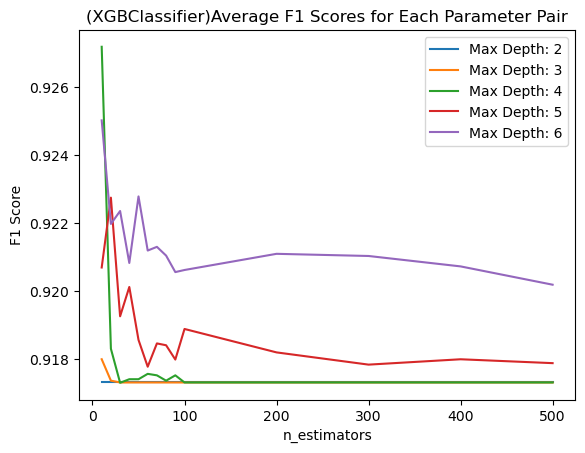

In [4]:
# Aggregate Accuracy values for each (n_estimators, max_depth) pair
f1_aggregate = {}

for entry in model_performance:
    key = (entry['n_estimators'], entry['max_depth'])
    if key not in f1_aggregate:
        f1_aggregate[key] = []
    f1_aggregate[key].append(entry['F1'])

# Calculate average Accuracy for each pair
average_f1 = {k: sum(v)/len(v) for k, v in f1_aggregate.items()}

df = pd.DataFrame([{'n_estimators': k[0], 'max_depth': k[1], 'f1_score': v} for k, v in average_f1.items()])

for depth in sorted(df['max_depth'].unique()):
    subset = df[df['max_depth'] == depth]
    plt.plot(subset['n_estimators'], subset['f1_score'], label=f'Max Depth: {depth}')
plt.xlabel('n_estimators')
plt.ylabel('F1 Score')
plt.title('(XGBClassifier)Average F1 Scores for Each Parameter Pair')
plt.legend()
plt.show()

In [5]:
print(f"Best parameters: n_estimators={best_params[0]}, max_depth={best_params[1]} with F1: {best_score}")

Best parameters: n_estimators=10, max_depth=4 with F1: 0.9271834715107203


# Find important feature

In [6]:
envGen = get_train_environment(n_splits=5)
# The holdout set is not included in the cross validation folds, use it at the very end to evaluate overall performance
stats, X, X_holdout, y, y_holdout = next(envGen)

# Initialize variables to track important features num
print(len(X[0]))
featureNums = range(1, len(X[0]), 10)
featureNumf1s = {}

# Cross validation folds
for fold, stats, X_train, X_test, y_train, y_test in envGen:
    print(f"Fold: {fold}")
    class_y_train = [0 if value == 0 else 1 for value in y_train]
    class_y_test = [0 if value == 0 else 1 for value in y_test]
    
    model = RandomForestClassifier(n_estimators=best_params[0], max_depth=best_params[1])
    model.fit(X_train, class_y_train)

    # print(model.feature_importances_)
    # make predictions for test data and evaluate
    predictions = model.predict(X_test)
    f1 = f1_score(class_y_test, predictions)
    print("Overall Fold F1: ", f1)
    
    thresholds = enumerate(model.feature_importances_)
    thresholds = [x for x in thresholds]
    thresholds.sort(key=lambda x: x[1], reverse=True)
    
    eps = 0.00001
    lastf1 = None
    for featureNum in featureNums:
        selectedFeatures = [i for i, x in thresholds[:featureNum]]
        
        model = RandomForestClassifier(n_estimators=best_params[0], max_depth=best_params[1])
        XT = X_train[:, selectedFeatures]
        model.fit(XT, class_y_train)
        
        predictions = model.predict(X_test[:, selectedFeatures])
        f1 = f1_score(class_y_test, predictions)
        
        if lastf1 is not None:
            if np.abs(f1 - lastf1) < eps:
                print(np.abs(f1 - lastf1))
                print(f1)
                break
            else:
                lastf1 = f1
        else:
            lastf1 = f1
        
        if featureNum in featureNumf1s:
            featureNumf1s[featureNum].append(f1)
        else:
            featureNumf1s[featureNum] = [f1]
        
        print(f"FeatureNum: {featureNum}")
        print("FeatureNum F1: ", f1)

avgFeatureNumf1s = {x: np.mean(featureNumf1s[x]) for x in featureNumf1s}
optimal_FeatureNum = [max(avgFeatureNumf1s, key=avgFeatureNumf1s.get),avgFeatureNumf1s[max(avgFeatureNumf1s, key=avgFeatureNumf1s.get)]]
print("Optimal # of features: ",optimal_FeatureNum[0],", F1: ",optimal_FeatureNum[1])

Found cached folds, using those
1574
Fold: 0
Overall Fold F1:  0.9180799080195459
FeatureNum: 1
FeatureNum F1:  0.9202096680256261
FeatureNum: 11
FeatureNum F1:  0.9758214507129572
FeatureNum: 21
FeatureNum F1:  0.9707782220855122
FeatureNum: 31
FeatureNum F1:  0.9530080814127506
FeatureNum: 41
FeatureNum F1:  0.9607250755287008
FeatureNum: 51
FeatureNum F1:  0.9624697336561744
FeatureNum: 61
FeatureNum F1:  0.9607250755287008
FeatureNum: 71
FeatureNum F1:  0.9620176238225464
FeatureNum: 81
FeatureNum F1:  0.9527794381350868
FeatureNum: 91
FeatureNum F1:  0.9390638798940241
FeatureNum: 101
FeatureNum F1:  0.9386430678466076
FeatureNum: 111
FeatureNum F1:  0.9409681227863047
FeatureNum: 121
FeatureNum F1:  0.9443457667258734
FeatureNum: 131
FeatureNum F1:  0.9387514723203769
FeatureNum: 141
FeatureNum F1:  0.9335285505124451
FeatureNum: 151
FeatureNum F1:  0.9275952311718524
FeatureNum: 161
FeatureNum F1:  0.9358335774978025
FeatureNum: 171
FeatureNum F1:  0.9453357100415923
FeatureNum:

Text(0.5, 1.0, 'RandomForestClassifier feature number vs F1')

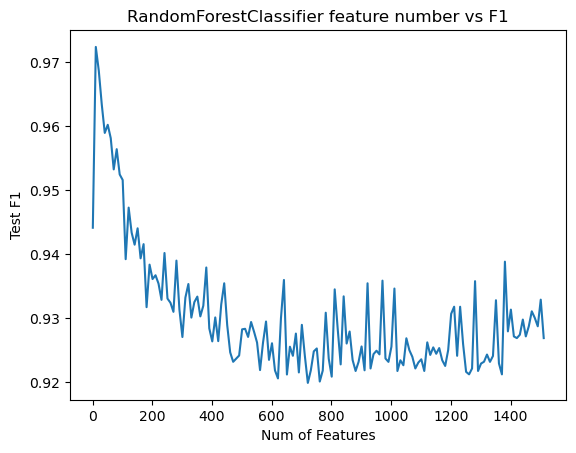

In [7]:
ax = sns.lineplot(pd.Series(avgFeatureNumf1s))
ax.set_xlabel("Num of Features")
ax.set_ylabel("Test F1")
ax.set_title("RandomForestClassifier feature number vs F1")

# Create final RFClassifier model after tuning & select important features

In [8]:
envGen = get_train_environment(n_splits=50)
# The holdout set is not included in the cross validation folds, use it at the very end to evaluate overall performance
stats, X, X_holdout, y, y_holdout = next(envGen)

final_f1s = []
final_selection_intersection = set()
allSelecteds = []

# Cross validation folds
for fold, stats, X_train_fold, X_test_fold, y_train_fold, y_test_fold in envGen:
    print(f"Fold: {fold}")
    class_y_train = [0 if value == 0 else 1 for value in y_train_fold]
    class_y_test = [0 if value == 0 else 1 for value in y_test_fold]
    
    model = RandomForestClassifier(n_estimators=best_params[0], max_depth=best_params[1])
    model.fit(X_train_fold, class_y_train)

    print(model.feature_importances_)
    # make predictions for test data and evaluate
    pre_predictions = model.predict(X_test_fold)

    pre_f1 = f1_score(class_y_test, pre_predictions)
    print("Pre Selection F1: ", pre_f1)
    
    thresholds = enumerate(model.feature_importances_)
    thresholds = [x for x in thresholds]
    thresholds.sort(key=lambda x: x[1], reverse=True)
    
    selectedFeatures = [i for i, x in thresholds[:optimal_FeatureNum[0]]]
    allSelecteds.append(selectedFeatures)
    
    if len(final_selection_intersection) == 0:
        final_selection_intersection = final_selection_intersection.union(selectedFeatures)
    else:
        final_selection_intersection = final_selection_intersection.intersection(selectedFeatures)
    
    model = RandomForestClassifier(n_estimators=best_params[0], max_depth=best_params[1])
    
    XT = X_train_fold[:, selectedFeatures]
    model.fit(XT, class_y_train)

    post_predictions = model.predict(X_test_fold[:, selectedFeatures])
    post_f1 = f1_score(class_y_test, post_predictions)
    print("Post Selection F1: ", post_f1)
    final_f1s.append(post_f1)

Found cached folds, using those
Fold: 0
[4.24486417e-02 0.00000000e+00 4.02212547e-06 ... 3.40793089e-02
 0.00000000e+00 0.00000000e+00]
Pre Selection F1:  0.9444444444444444
Post Selection F1:  0.9825581395348837
Fold: 1
[0.01766745 0.01111835 0.000498   ... 0.00200099 0.00179138 0.        ]
Pre Selection F1:  0.9106628242074928
Post Selection F1:  0.9691358024691358
Fold: 2
[0.03309018 0.00967115 0.01344646 ... 0.04178692 0.00016625 0.00181994]
Pre Selection F1:  0.9470752089136489
Post Selection F1:  0.9709302325581395
Fold: 3
[0.00097348 0.14293054 0.         ... 0.00254046 0.00182402 0.        ]
Pre Selection F1:  0.888235294117647
Post Selection F1:  0.9741935483870968
Fold: 4
[0.00036792 0.0607504  0.         ... 0.00371297 0.         0.00378821]
Pre Selection F1:  0.9265536723163842
Post Selection F1:  0.9848024316109422
Fold: 5
[0.         0.10567917 0.         ... 0.00564195 0.01714618 0.00260643]
Pre Selection F1:  0.898550724637681
Post Selection F1:  0.9554140127388535
Fol

In [9]:
print("Final RFClassifier model's avg. F1:",np.mean(final_f1s))

Final RFClassifier model's avg. F1: 0.966295589450568


Text(0.5, 1.0, 'Final Random Forest Classifier Model CV Results')

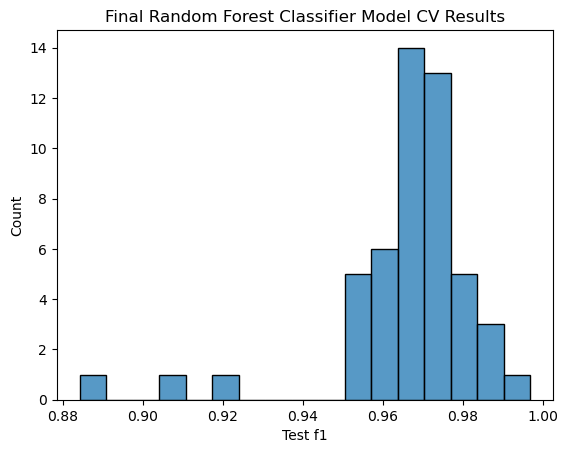

In [10]:
ax = sns.histplot(final_f1s)
ax.set_xlabel("Test f1")
ax.set_title("Final Random Forest Classifier Model CV Results")

In [11]:
def feature_labels(features):
    data = pd.read_csv("FinalData.csv")
    data = data.drop(["Name", "appid", 'ln.pricep1', "Unnamed: 0"], axis=1)
    data_columns = data.columns.tolist()
    return [x for i, x in enumerate(data_columns) if i in features]

In [12]:
rf_class_final_features = feature_labels(final_selection_intersection)
print(rf_class_final_features)

['tag_Free to Play']
